In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cd_data_24x128_p1

model_dir = 'output/cd_24x128_p1_more_complex_20220803_94d2'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cd_data_24x128_p1()
config_name = "more_complex"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)


Split: time,120; Training: 22135; Validation: 0; Testing: 4427


In [3]:
trainer.setup()

Resuming from 2620...


In [4]:
trainer.compute_predictions_losses()

Computing test predictions...Done. 0.527, 0.429
00:00:28.92
Computing train predictions...Done. 0.006, 0.994
00:02:46.91
Computing validation predictions...Done. nan, nan
00:02:46.91


In [5]:
print(trainer.perf_str)

Loss:
  Train:	0.006
  Valid:	nan
  Test: 	0.527

R2:
  Train:	0.994
  Valid:	nan
  Test: 	0.429


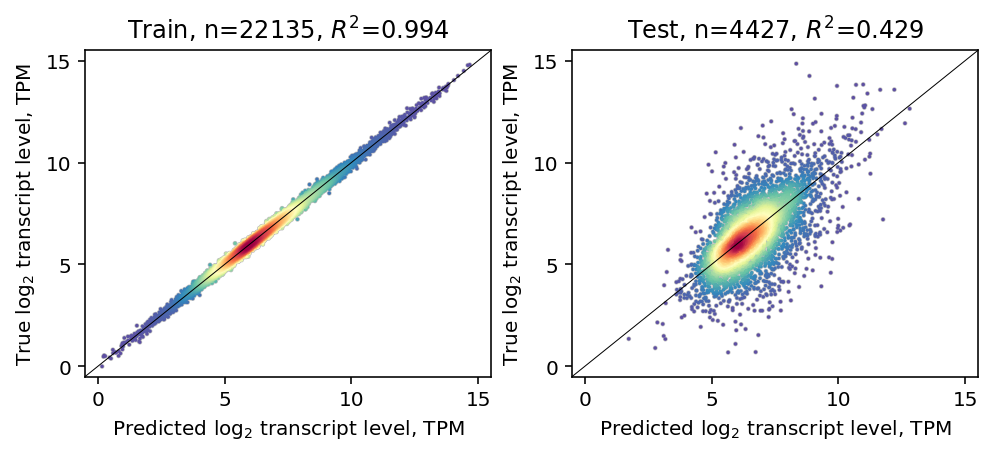

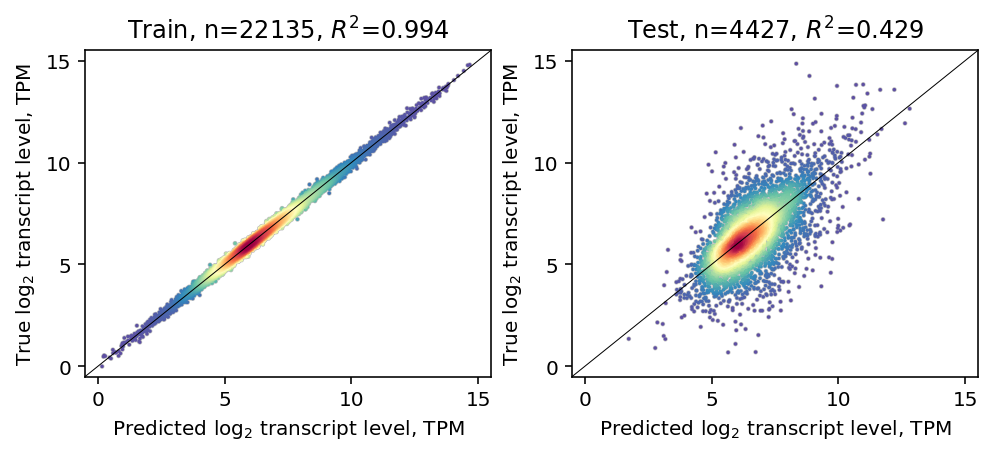

In [6]:
trainer.plot_predictions()

In [7]:
from scipy.stats import spearmanr

test_tx = trainer.test_tx
test_predictions = trainer.test_predictions

dataset = trainer.dataloader.dataset

y = dataset.unscale_log_tx(test_tx)
x = dataset.unscale_log_tx(test_predictions)

spearmanr(test_tx, test_predictions), spearmanr(x, y)


(SpearmanrResult(correlation=0.6332674427428816, pvalue=0.0),
 SpearmanrResult(correlation=0.6332674427428815, pvalue=0.0))

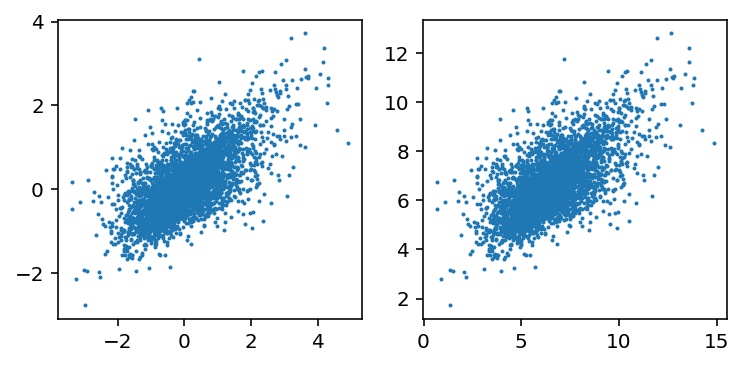

In [8]:
plt.figure(figsize=(6, 2.75))
plt.subplot(1, 2, 1)
plt.scatter(test_tx, test_predictions, s=1)

plt.subplot(1, 2, 2)
plt.scatter(y, x, s=1)

0.4288450691743684

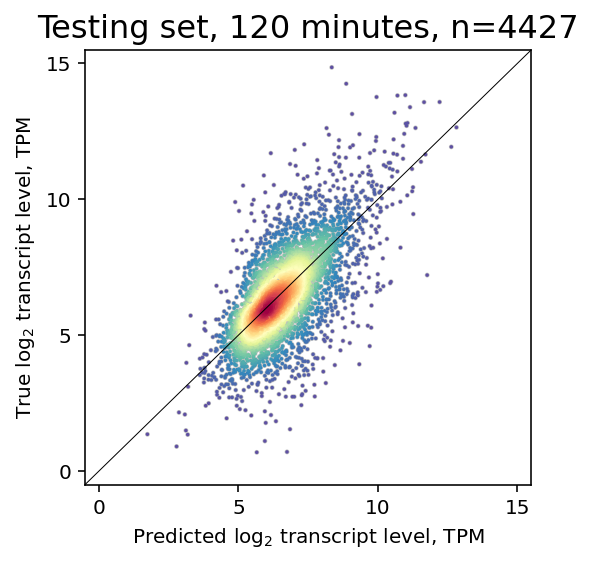

In [9]:
from src.vit_viz import plot_scatter_predicted_true
from sklearn.metrics import r2_score

plt.figure(figsize=(4, 4))

y = vit_data.unscale_log_tx(trainer.test_tx)
x = vit_data.unscale_log_tx(trainer.test_predictions)

test_r2 = plot_scatter_predicted_true(x, y, "Testing set, 120 minutes")
r2_score(trainer.test_tx, trainer.test_predictions)


In [10]:
tpm_df = vit_data.read_log_tpm_data()

In [11]:
tpm_df.head(2)

time,0.0,7.5,15.0,30.0,60.0,120.0
orf_name,,,,,,
YAL001C,5.018297,4.690297,5.358192,5.635665,5.786156,5.906502
YAL002W,4.920433,4.960072,5.729812,6.254715,6.613016,6.581889


In [12]:
orf_names = trainer.dataloader.testloader.dataset[:][2]
data = pd.DataFrame(index=orf_names, data={'true': y, 'predicted': x})
data['diff'] = np.abs(data.true - data.predicted)

data = data.join(tpm_df)
data['diff_60'] = np.abs(data[60.0] - data['true'])


In [13]:

data[(data['diff'] < 2) & (data['true'] > 10)].sort_values('diff_60', ascending=False).head(2)

,true,predicted,diff,0.0,7.5,15.0,30.0,60.0,120.0,diff_60
YPL223C,13.576574,12.208846,1.367728,2.373205,2.144881,3.407241,7.943675,11.895816,13.576574,1.680758
YBR101C,10.060407,8.803398,1.257009,7.667255,9.962837,10.925976,7.803036,8.693286,10.060407,1.367121


In [14]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter


0

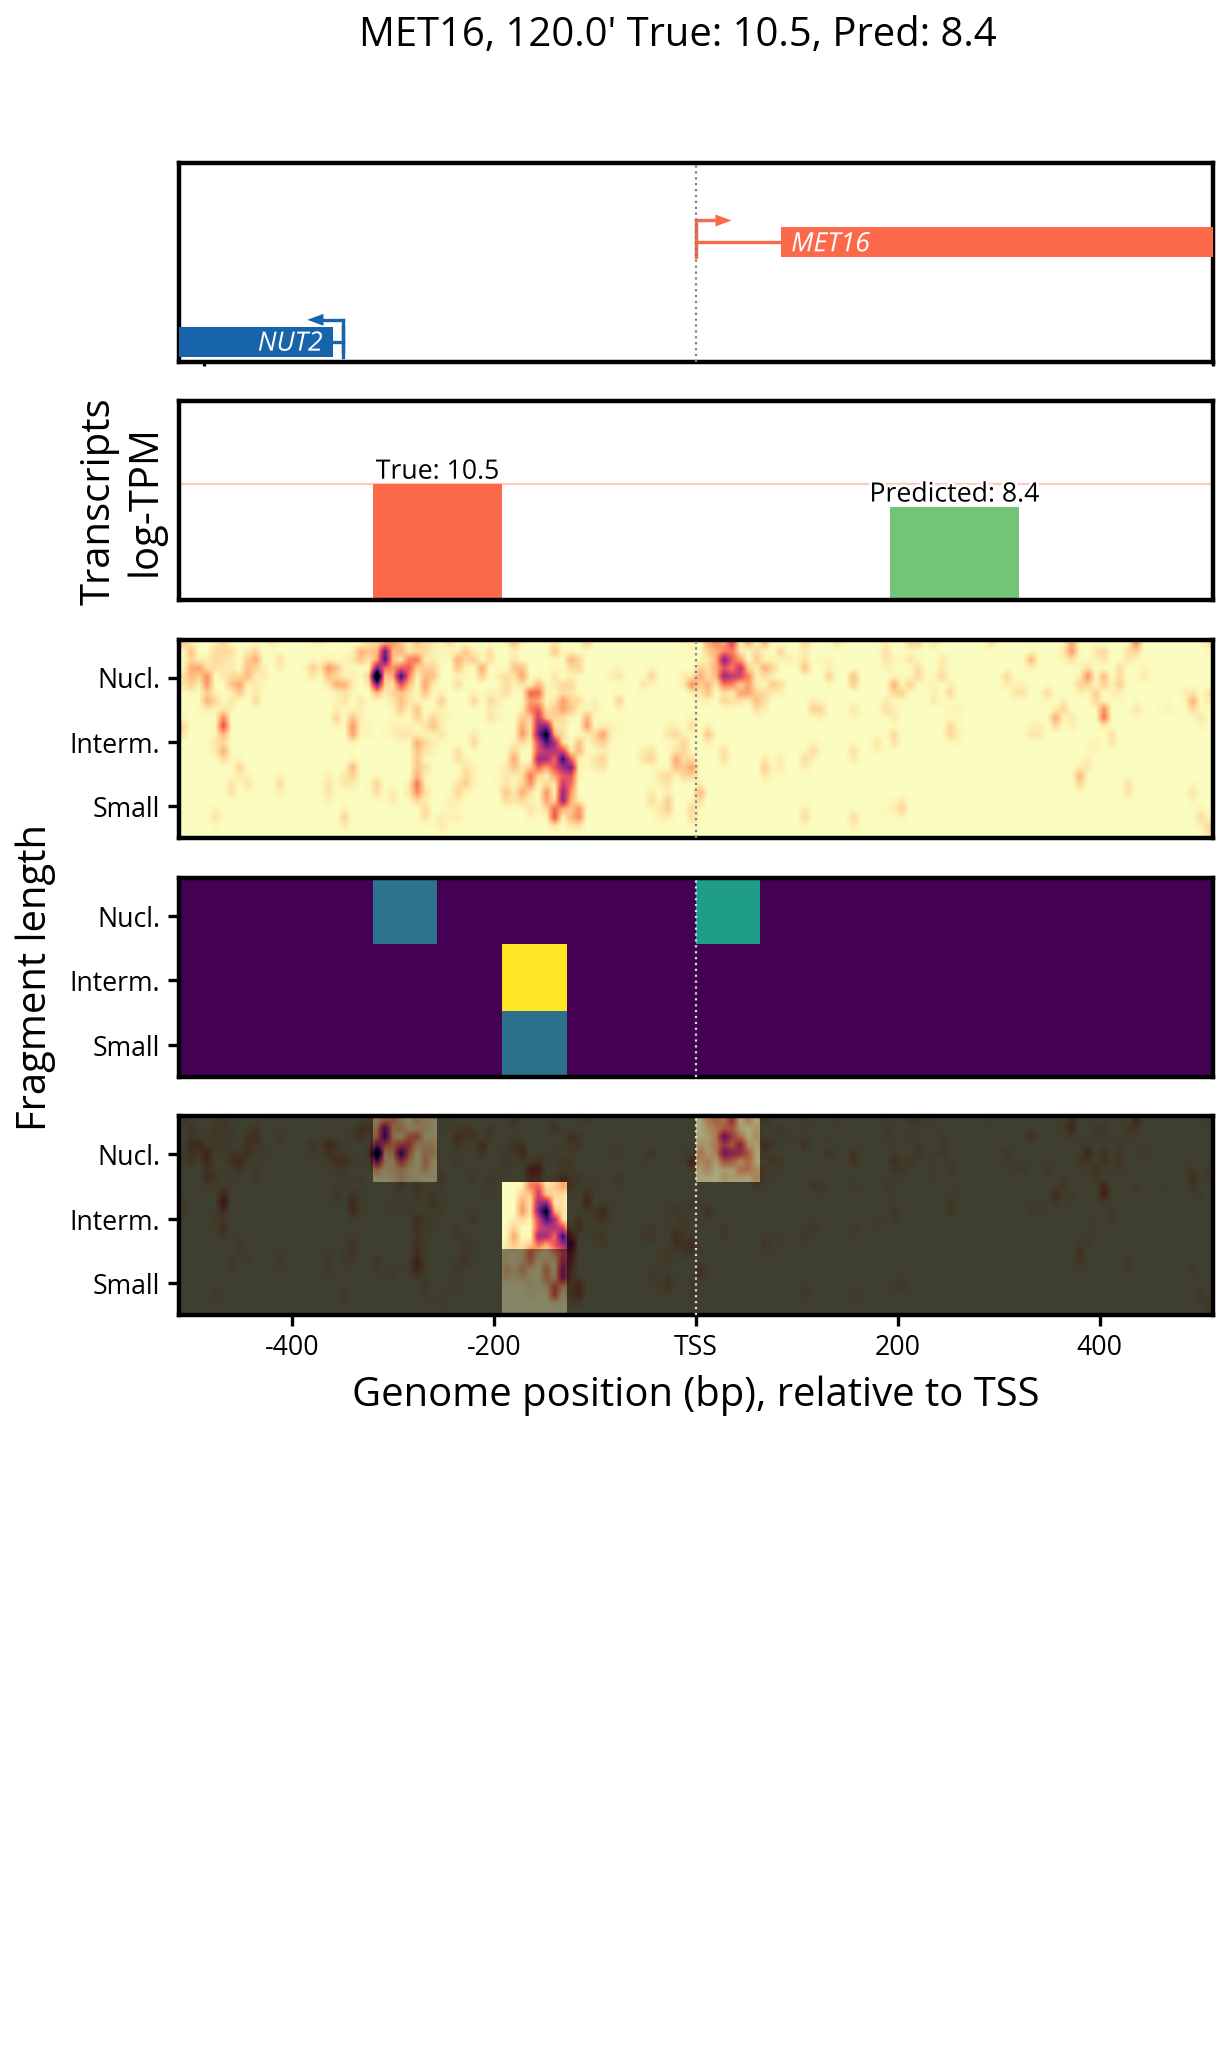

In [15]:
from src.vit_viz import plot_gene_prediction

trainer.plot_gene('MET16', 120.0)
0

0

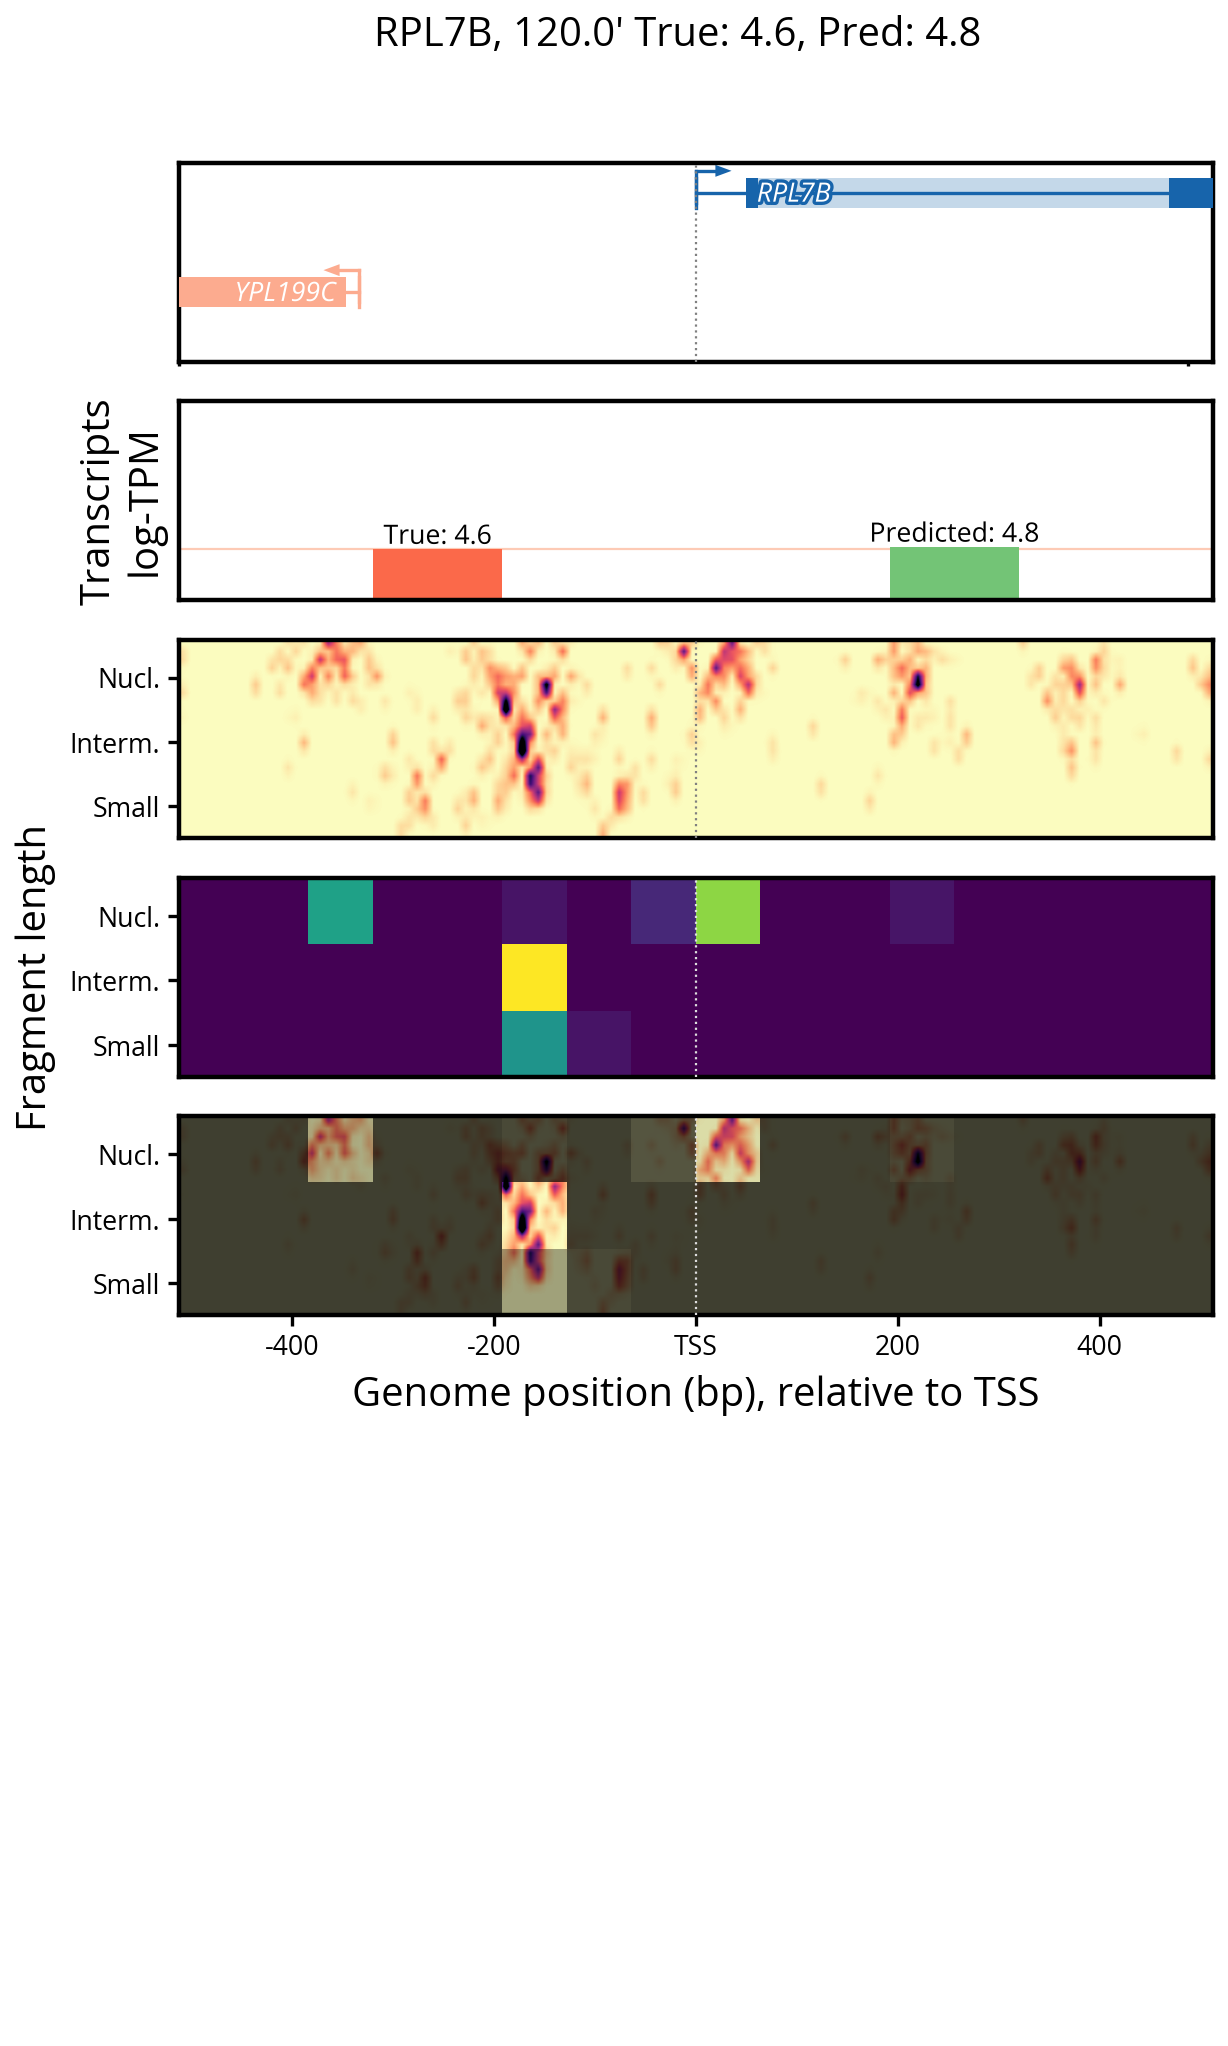

In [16]:
from src.vit_viz import plot_gene_prediction

trainer.plot_gene('RPL7B', 120.0)
0

In [17]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

1/4427 - 00:00:00.13
1001/4427 - 00:01:19.71
2001/4427 - 00:02:52.39
3001/4427 - 00:04:07.47
4001/4427 - 00:05:23.99


In [27]:
a_analysis.cd_120_cluster_labels

array([ 8,  9,  1, ...,  6,  7, 15], dtype=int32)

In [33]:
a_analysis.cl_df['new_cluster_name'] = np.arange(len(a_analysis.cl_df))+1
a_analysis.cl_df

,cluster_original,q0_120,q25_120,med_120,q75_120,q100_120,new_cluster_name
8,8.0,0.703283,6.940357,5.896128,6.940357,11.143288,1
6,6.0,1.340625,6.573605,5.897023,6.573605,9.388833,2
2,2.0,1.772140,6.911878,5.976854,6.911878,10.432740,3
15,15.0,1.352248,7.283843,6.080519,7.283843,10.753508,4
12,12.0,2.058811,7.003743,6.104091,7.003743,10.949125,5
3,3.0,2.735321,6.999633,6.108223,6.999633,10.977535,6
0,0.0,2.195495,6.949134,6.134135,6.949134,10.518099,7
7,7.0,0.902886,7.375720,6.279627,7.375720,10.439174,8
10,10.0,2.707582,7.249150,6.363824,7.249150,12.393729,9
1,1.0,0.687291,7.499359,6.435822,7.499359,13.570704,10


In [39]:
from src.utils import write_pickle

new_cluster_labels = np.array([a_analysis.cl_df.loc[c]['new_cluster_name'] 
                               for c in a_analysis.cd_120_cluster_labels]).astype(int)

write_pickle(new_cluster_labels, f"output/cd_24x128_p1_more_complex_20220803_94d2/clus_labels.pkl")


Wrote output/cd_24x128_p1_more_complex_20220803_94d2/clus_labels.pkl


Directory exists. Skipping.


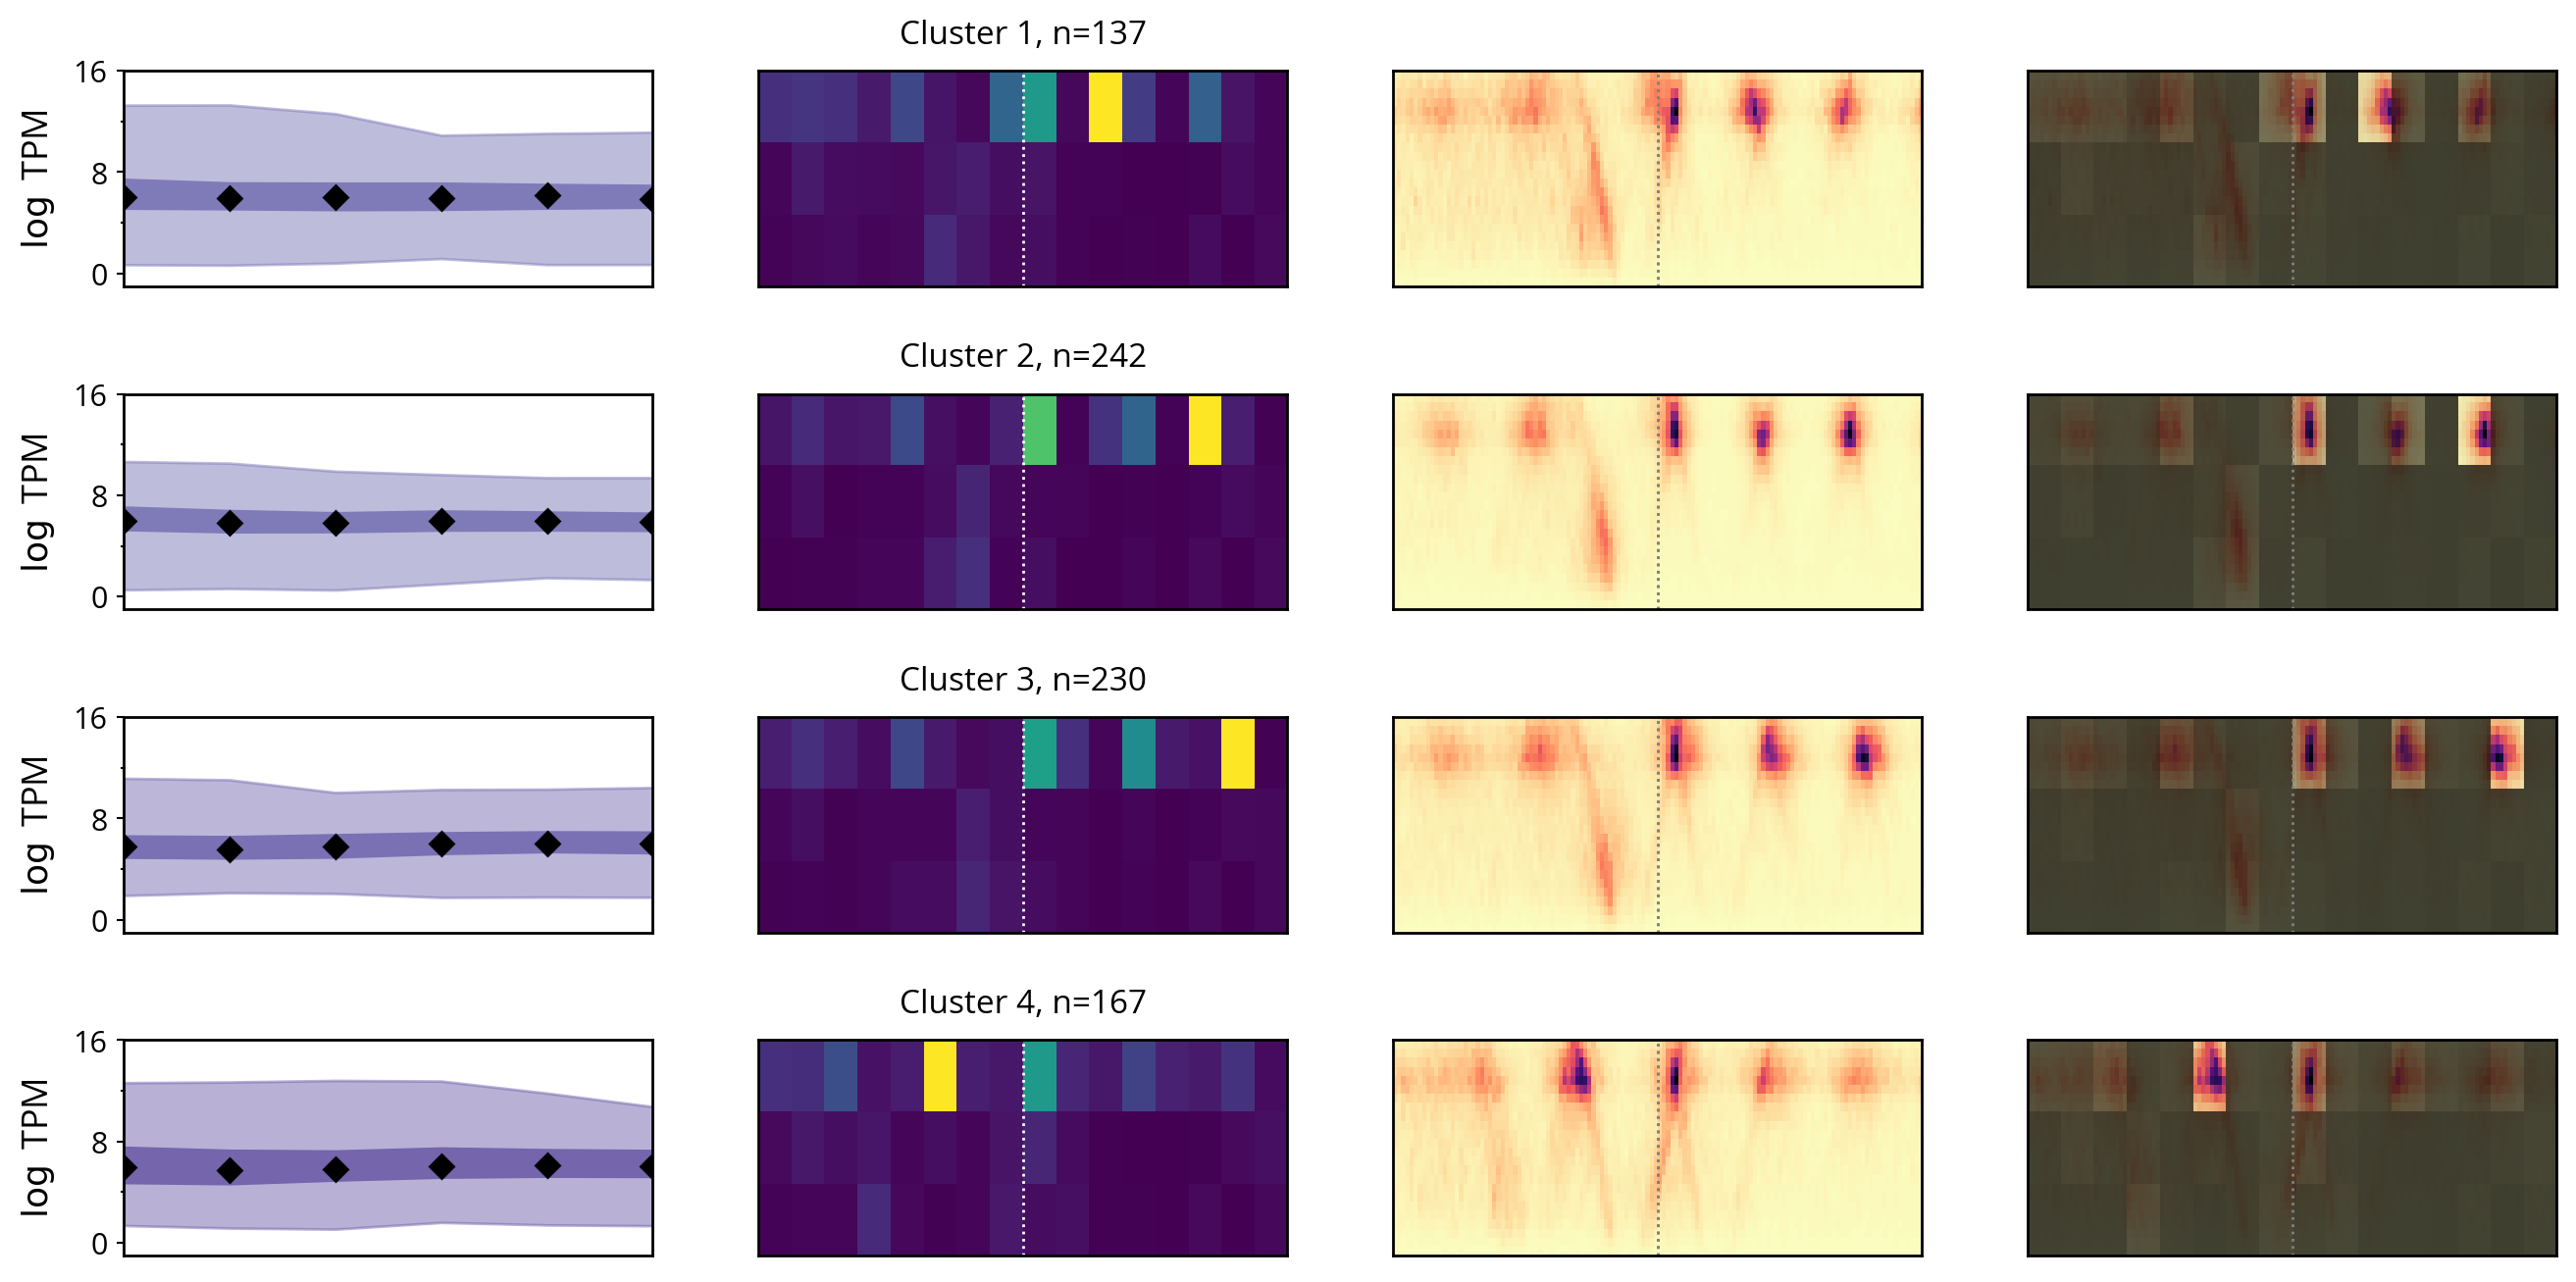

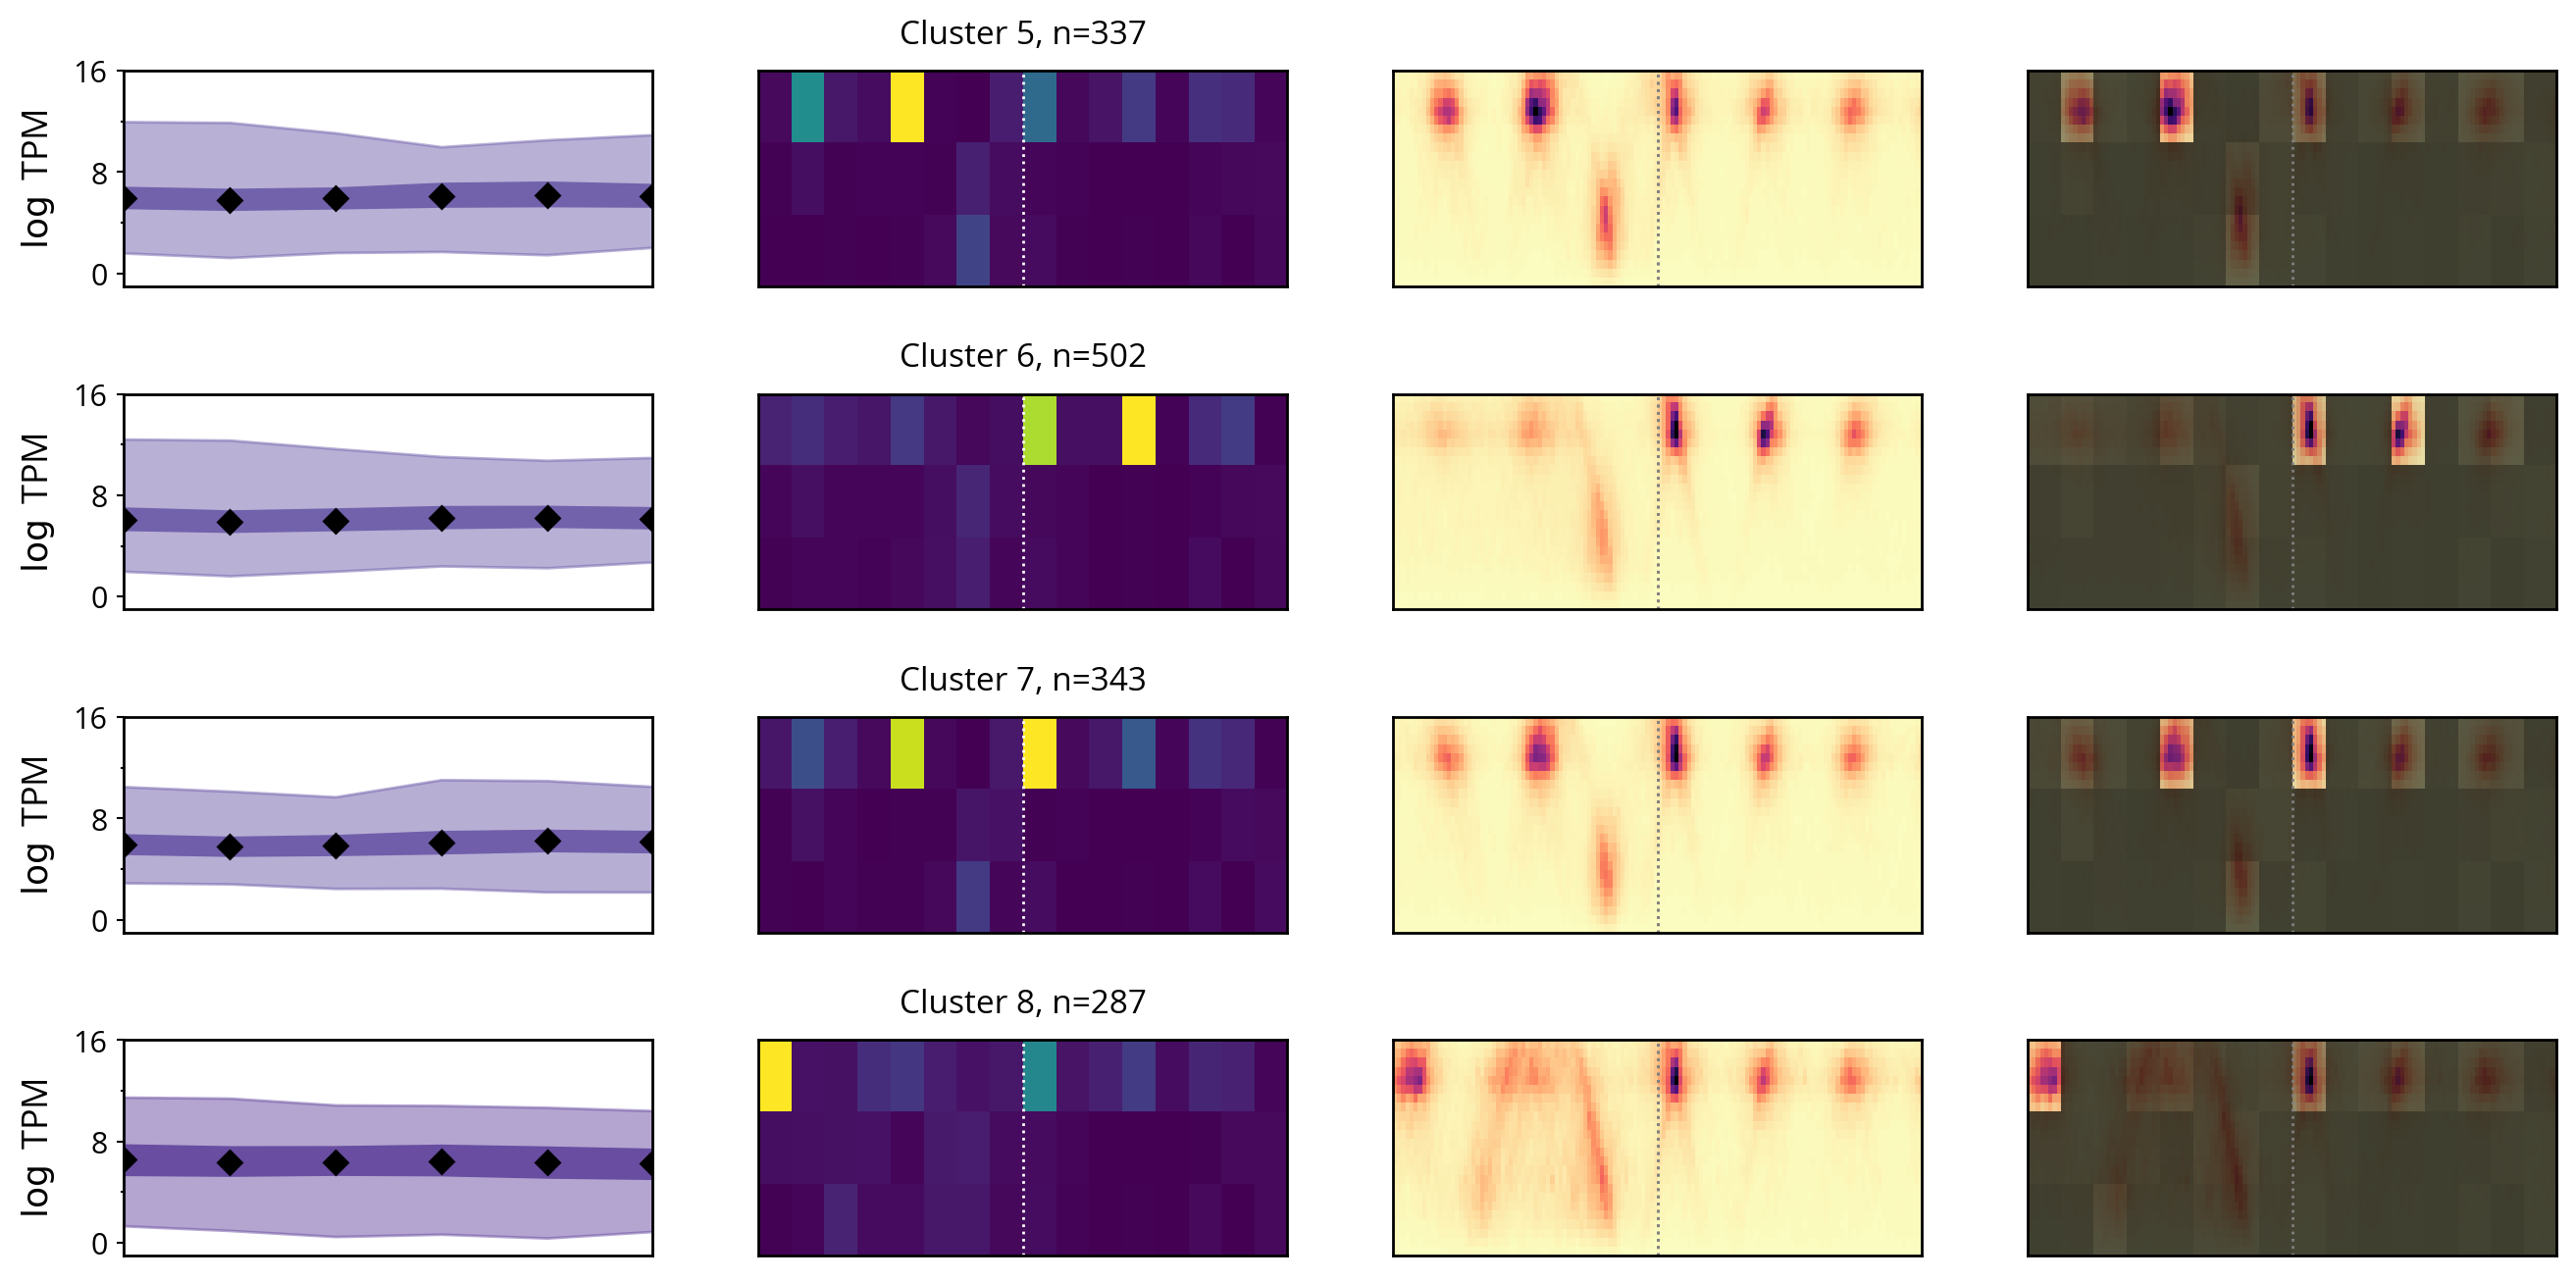

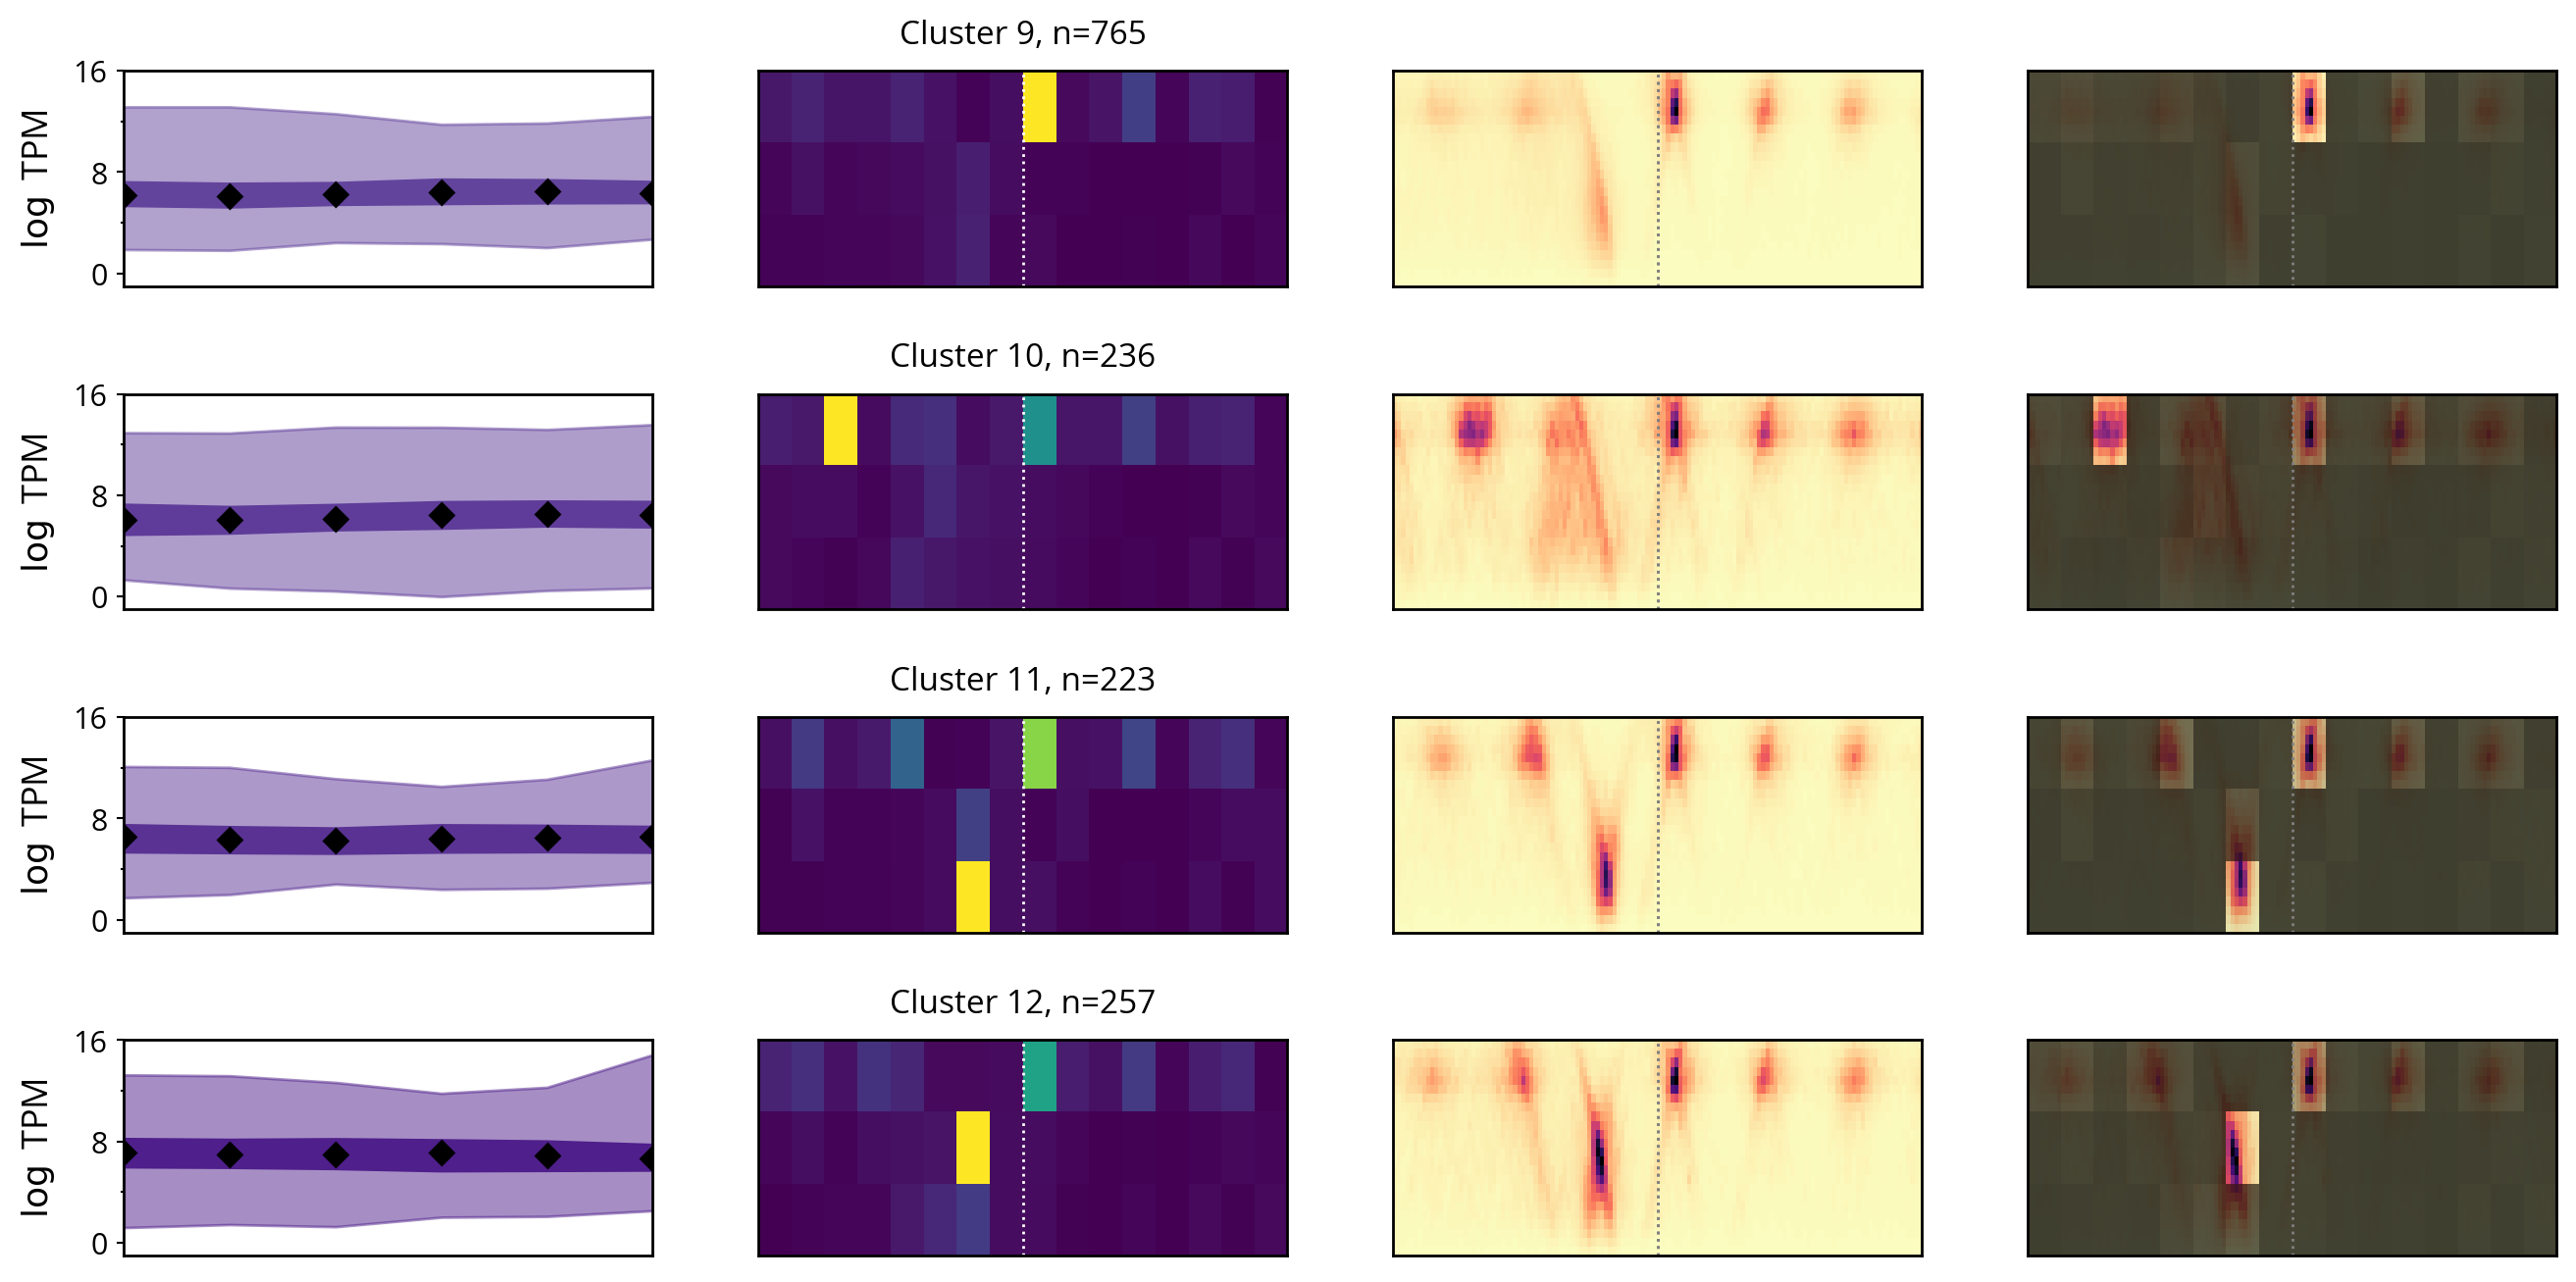

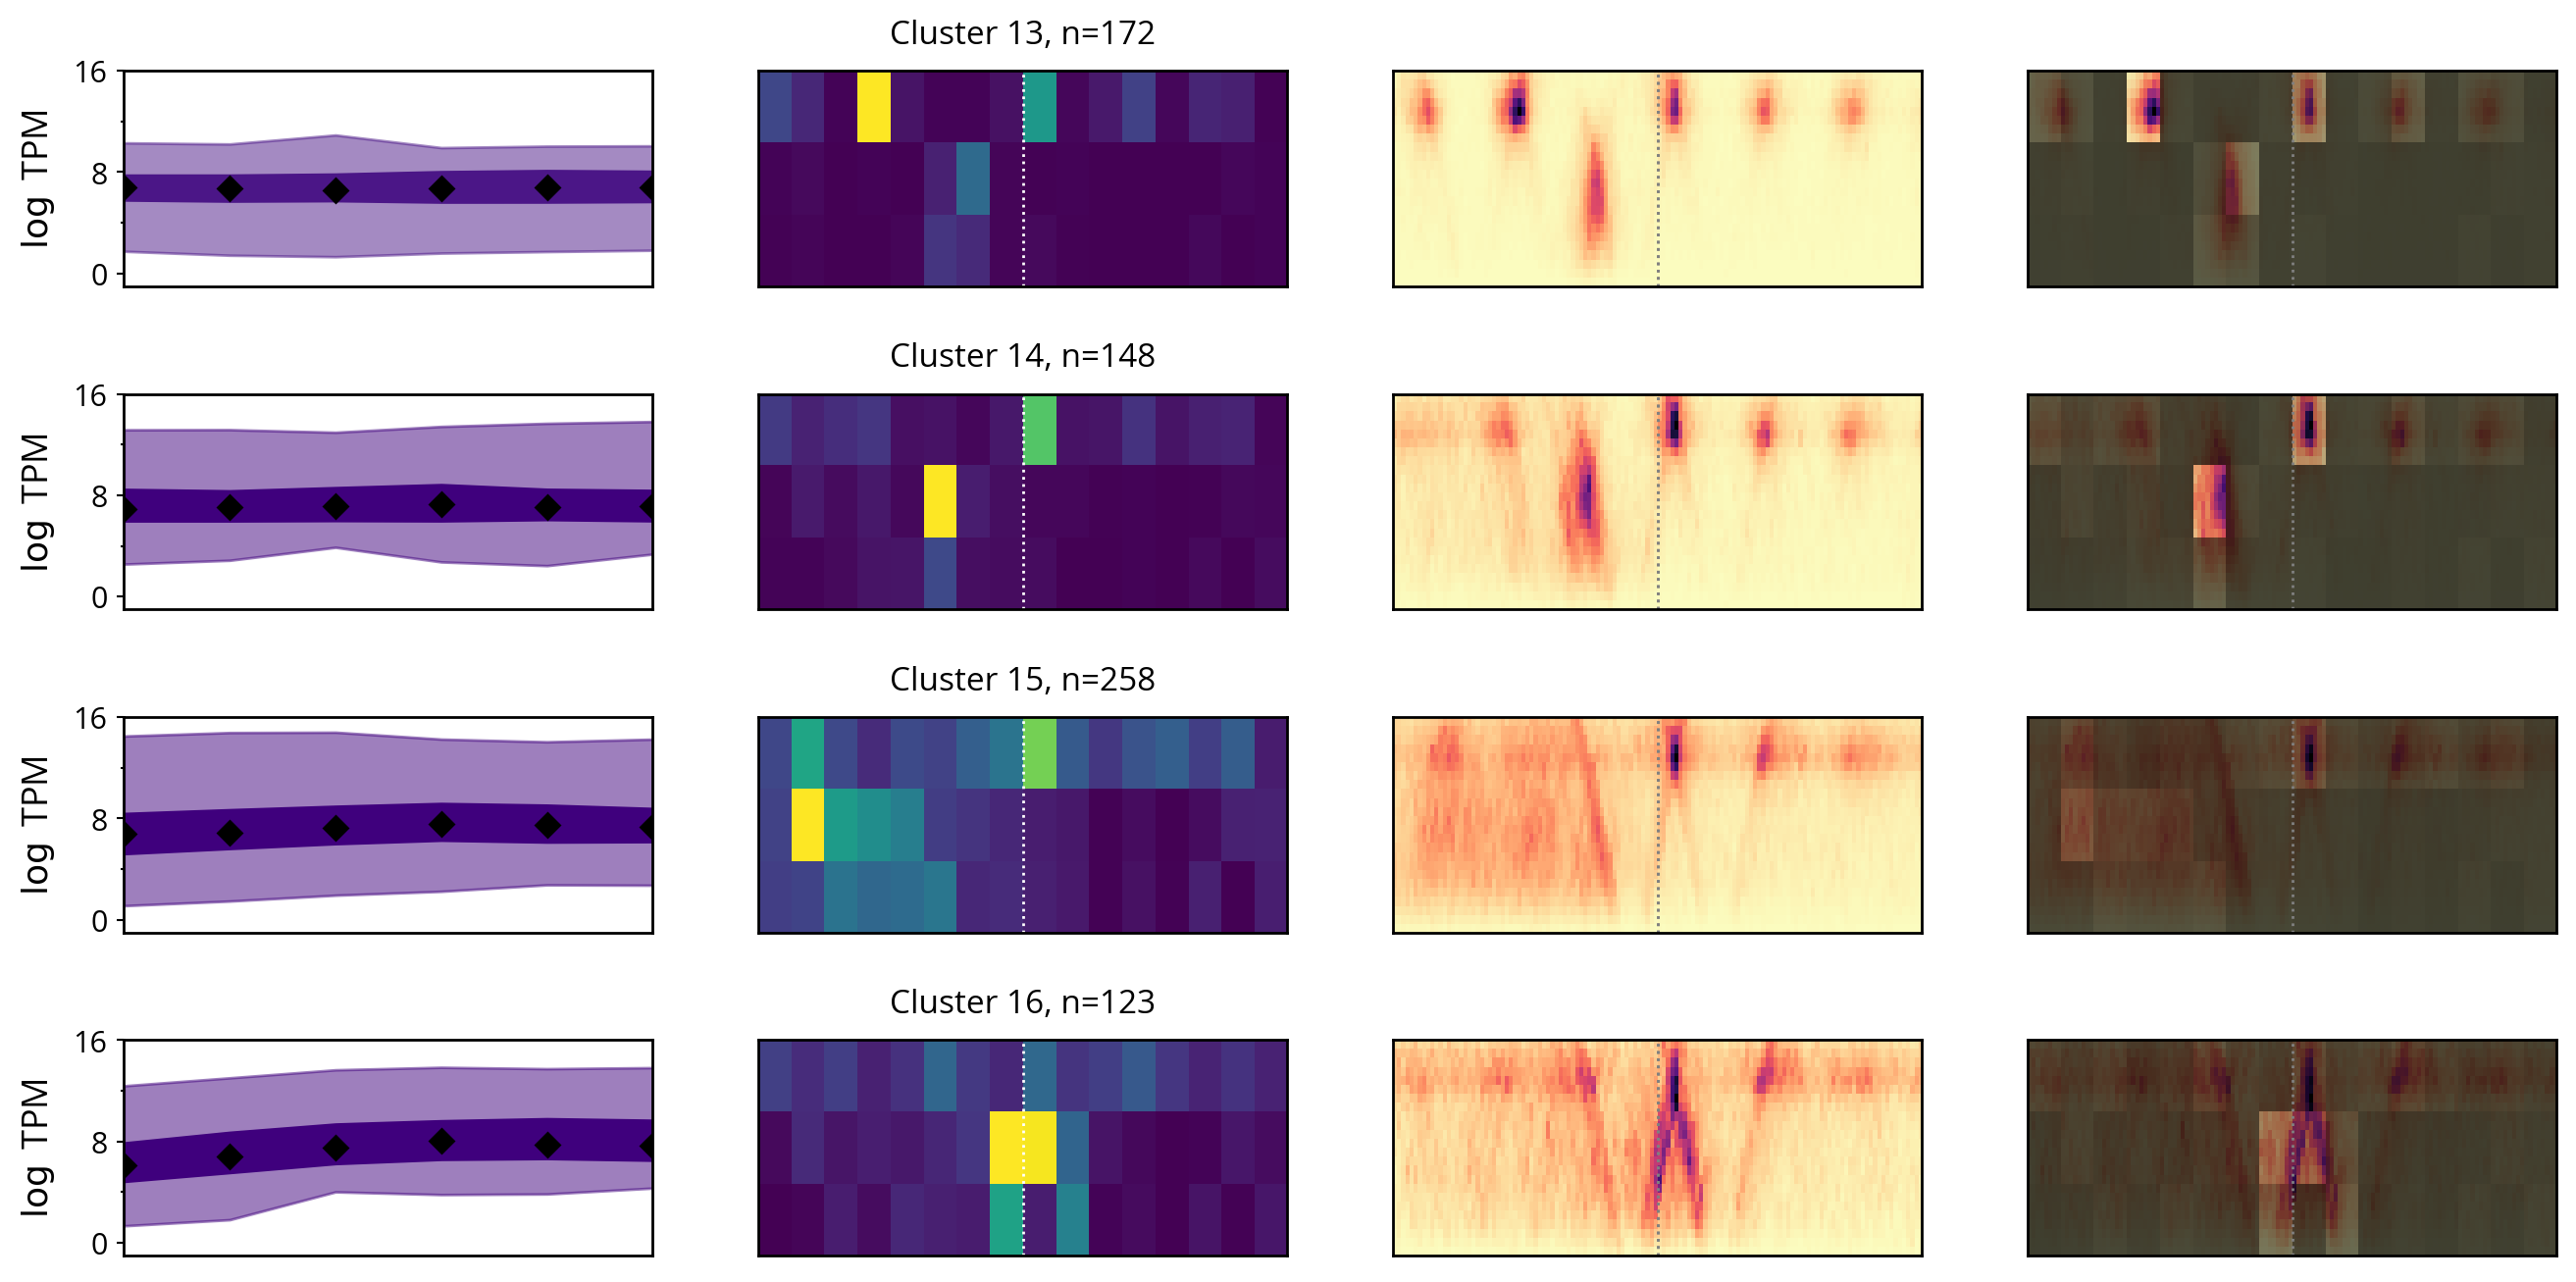

In [22]:
a_analysis.plot_clusters()

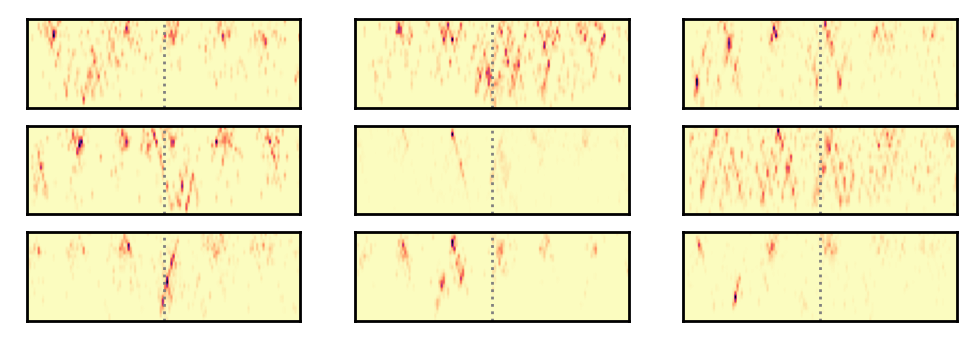

In [19]:
a_analysis.plot_cluster_examples(16)